In [64]:
from keras.utils import register_keras_serializable  
import numpy as np  
from pandas import read_csv, DataFrame, concat  
from sklearn.preprocessing import MinMaxScaler  
from keras.models import Model  
from keras.layers import (  
    Input, LSTM, Dense, Dropout, Concatenate,  
    LayerNormalization, MultiHeadAttention, Add,  
    GlobalAveragePooling1D, Lambda  
)  
from keras.callbacks import EarlyStopping, ReduceLROnPlateau  
import tensorflow as tf  

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):  
    # 和原本一样，可以做多变量  
    n_vars = 1 if type(data) is list else data.shape[1]  
    df = DataFrame(data)  
    cols, names = list(), list()  
    for i in range(n_in, 0, -1):  
        cols.append(df.shift(i))  
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]  
    for i in range(0, n_out):  
        cols.append(df.shift(-i))  
        if i == 0:  
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]  
        else:  
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]  
    agg = concat(cols, axis=1)  
    agg.columns = names  
    if dropnan:  
        agg.dropna(inplace=True)  
    return agg  

def positional_encoding(length, depth):  
    depth = depth / 2  
    positions = np.arange(length)[:, np.newaxis]  
    depths = np.arange(depth)[np.newaxis, :] / depth  
    angle_rates = 1 / (10000**depths)  
    angle_rads = positions * angle_rates  
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)  
    pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)  
    return pos_encoding  

@register_keras_serializable()  
def add_positional_encoding(inputs):  
    seq_len = inputs.shape[1]  
    d_model = inputs.shape[2]  
    pos_encoding = positional_encoding(seq_len, d_model)  
    return inputs + pos_encoding  

def transformer_encoder(inputs, head_num=4, ff_dim=64, dropout=0.2):  
    x = Lambda(add_positional_encoding)(inputs)  
    attn_output = MultiHeadAttention(num_heads=head_num, key_dim=x.shape[-1])(x, x)  
    attn_output = Dropout(dropout)(attn_output)  
    out1 = Add()([x, attn_output])  
    out1 = LayerNormalization(epsilon=1e-6)(out1)  

    ffn_output = Dense(ff_dim, activation='relu')(out1)  
    ffn_output = Dense(x.shape[-1])(ffn_output)  
    ffn_output = Dropout(dropout)(ffn_output)  
    out2 = Add()([out1, ffn_output])  
    out2 = LayerNormalization(epsilon=1e-6)(out2)  
    return out2  

class MultiModalTransformerLSTMModel:  
    def __init__(self, price_path, sentiment_path, look_back=10):  
        self.price_path = price_path  
        self.sentiment_path = sentiment_path  
        self.look_back = look_back  
        self.scaler_price = MinMaxScaler(feature_range=(0, 1))  
        self.scaler_sentiment = MinMaxScaler(feature_range=(0, 1))  
        self.scaler_y = MinMaxScaler(feature_range=(0, 1))  
        self.model = None  

    def load_and_prepare_data(self):
    # 加载对齐的原始数据
        price_df = read_csv(self.price_path, header=0, index_col=0)
        sentiment_df = read_csv(self.sentiment_path, header=0, index_col=0)
        df = price_df.join(sentiment_df, how='inner')
        values = df.values.astype('float32')

        total_len = len(values)
        look_back = self.look_back

    # 分好训练/测试
        train_size = int(total_len * 0.7)
        train_values = values[:train_size]
        test_values = values[train_size - look_back:]

    # fit scaler
        self.scaler_price.fit(train_values[:, 0:1])
        self.scaler_sentiment.fit(train_values[:, 1:2])
        self.scaler_y.fit(train_values[:, 0:1])  # fit 这里没错

    # 归一化特征
        price_train_scaled = self.scaler_price.transform(train_values[:, 0:1])
        sent_train_scaled = self.scaler_sentiment.transform(train_values[:, 1:2])
        price_test_scaled = self.scaler_price.transform(test_values[:, 0:1])
        sent_test_scaled = self.scaler_sentiment.transform(test_values[:, 1:2])

        train_scaled = np.hstack([price_train_scaled, sent_train_scaled])
        test_scaled = np.hstack([price_test_scaled, sent_test_scaled])

    # 新写法：Y拿原始数据的价格
        def window_xy(data_scaled, original_values, start_idx, look_back):
            X1, X2, Y = [], [], []
            for i in range(len(data_scaled) - look_back):
                price_hist = data_scaled[i:i+look_back, 0]
                sent_hist = data_scaled[i:i+look_back, 1]
                price_next = original_values[start_idx + i + look_back, 0]  # 直接从原始值拿
                X1.append(price_hist)
                X2.append(sent_hist)
                Y.append(price_next)
            X1 = np.array(X1).reshape(-1, look_back, 1)
            X2 = np.array(X2).reshape(-1, look_back, 1)
            Y = np.array(Y).reshape(-1, 1)
            return X1, X2, Y

        price_train_X, sent_train_X, train_y = window_xy(
             train_scaled, values, 0, look_back)
        price_test_X, sent_test_X, test_y = window_xy(
             test_scaled, values, train_size - look_back, look_back)

    # 归一化y
        train_y_scaled = self.scaler_y.transform(train_y)
        test_y_scaled = self.scaler_y.transform(test_y)

        print("scaler_y.data_min_:", self.scaler_y.data_min_)
        print("scaler_y.data_max_:", self.scaler_y.data_max_)
        print("test_y[:5]:", test_y[:5].flatten())
        print("test_y_scaled[:5]:", test_y_scaled[:5].flatten())
        test_y_inverse = self.scaler_y.inverse_transform(test_y_scaled)
        print("test_y反归一化[:5]:", test_y_inverse[:5].flatten())

        return (price_train_X, sent_train_X, train_y_scaled), (price_test_X, sent_test_X, test_y_scaled)

    def build_model(self):
    # 可自定义Transformer_encoder实现
        from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, GlobalAveragePooling1D, Lambda, Concatenate

        price_input = Input(shape=(self.look_back, 1), name="price_input")
        sentiment_input = Input(shape=(self.look_back, 1), name="sentiment_input")

    # 1. 汇率：LSTM编码（可自选层数/维度）
        price_feat = LSTM(50, return_sequences=True)(price_input)
        price_feat = Dropout(0.3)(price_feat)
        price_feat = LSTM(100, return_sequences=True)(price_feat)
        price_feat = LSTM(50, return_sequences=False)(price_feat)  # 输出shape=（batch, 50）

    # 2. 情感：Transformer编码
        sentiment_trans = transformer_encoder(sentiment_input, head_num=4, ff_dim=64, dropout=0.2)  # shape: (batch, seq, feat)
        sentiment_feat = GlobalAveragePooling1D()(sentiment_trans)  # shape: (batch, feat_dim)

    # 3. 加权融合
        price_weight = 1.0      # 可调整权重
        sentiment_weight = 0  # 推荐1~0.5等（不可为0，否则没影响）
        price_feat = Lambda(lambda x: x * price_weight)(price_feat)
        sentiment_feat = Lambda(lambda x: x * sentiment_weight)(sentiment_feat)
        merged = Concatenate()([price_feat, sentiment_feat])

    # 4. 全连接预测
        dense1 = Dense(64, activation='relu')(merged)
        drop1 = Dropout(0.3)(dense1)
        dense2 = Dense(32, activation='relu')(drop1)
        drop2 = Dropout(0.2)(dense2)
        output = Dense(1)(drop2)

        model = Model(inputs=[price_input, sentiment_input], outputs=output)
        model.compile(loss='mae', optimizer='adam')
        self.model = model
        return model

    def save(self, filepath):  
        if self.model is None:  
            raise ValueError("模型未构建，无法保存")  
        self.model.save(filepath)  

    def load(self, filepath):  
        from keras.models import load_model  
        self.model = load_model(filepath, compile=True)  

    def train(self, price_train_X, sentiment_train_X, train_y, epochs=100, batch_size=64, val_data=None):
        self.build_model()
       
        if val_data is not None:
            validation_data = val_data
        else:
            validation_data = None
        history = self.model.fit(
            [price_train_X, sentiment_train_X], train_y,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=validation_data,
            verbose=2,
            shuffle=False,
           
           )
        return history

    def predict(self, price_X, sentiment_X):  
        yhat = self.model.predict([price_X, sentiment_X])  
        yhat_inv = self.scaler_y.inverse_transform(yhat)  
        return yhat_inv


In [65]:
model = MultiModalTransformerLSTMModel('CNY_SGD_to_exchange_rate.csv', 'SGD_sentiment.csv', look_back=5)


(price_train_X, sentiment_train_X, train_y), (price_test_X, sentiment_test_X, test_y) = model.load_and_prepare_data()
history = model.train(
    price_train_X, sentiment_train_X, train_y,
    epochs=500, batch_size=64,
    val_data=([price_test_X, sentiment_test_X], test_y) 
)
predictions = model.predict(price_test_X, sentiment_test_X)

from sklearn.metrics import mean_absolute_error, mean_squared_error
y_true = model.scaler_y.inverse_transform(test_y)
mae = mean_absolute_error(y_true, predictions)
rmse = np.sqrt(mean_squared_error(y_true, predictions))
print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')


print("模型对测试集的预测结果：")
print(predictions.flatten())

y_true = model.scaler_y.inverse_transform(test_y.reshape(-1, 1))
print("测试集真实汇率：")
print(y_true.flatten())
print("test_y前10个:", test_y.flatten()[:10])
print("反归一化y_true前10个:", y_true.flatten()[:10])


scaler_y.data_min_: [5.2743]
scaler_y.data_max_: [5.4776]
test_y[:5]: [5.3939 5.3935 5.3821 5.3895 5.3746]
test_y_scaled[:5]: [0.58829117 0.5863228  0.53025055 0.5666504  0.4933586 ]
test_y反归一化[:5]: [5.3939 5.3935 5.3821 5.3895 5.3746]
Epoch 1/500
3/3 - 3s - 1s/step - loss: 0.5037 - val_loss: 1.1368
Epoch 2/500
3/3 - 0s - 26ms/step - loss: 0.4365 - val_loss: 0.9844
Epoch 3/500
3/3 - 0s - 25ms/step - loss: 0.3381 - val_loss: 0.7285
Epoch 4/500
3/3 - 0s - 25ms/step - loss: 0.2131 - val_loss: 0.3587
Epoch 5/500
3/3 - 0s - 26ms/step - loss: 0.2049 - val_loss: 0.1872
Epoch 6/500
3/3 - 0s - 26ms/step - loss: 0.2314 - val_loss: 0.3474
Epoch 7/500
3/3 - 0s - 26ms/step - loss: 0.1565 - val_loss: 0.5108
Epoch 8/500
3/3 - 0s - 25ms/step - loss: 0.1611 - val_loss: 0.5869
Epoch 9/500
3/3 - 0s - 25ms/step - loss: 0.1769 - val_loss: 0.5687
Epoch 10/500
3/3 - 0s - 26ms/step - loss: 0.1754 - val_loss: 0.4653
Epoch 11/500
3/3 - 0s - 25ms/step - loss: 0.1628 - val_loss: 0.3626
Epoch 12/500
3/3 - 0s - 27m

scaler_y.data_min_: [0.004988]
scaler_y.data_max_: [0.005609]
test_y[:5]: [0.004994 0.005006 0.005007 0.004997 0.005003]
test_y_scaled[:5]: [0.00966167 0.02898598 0.03059673 0.01449299 0.02415562]
test_y反归一化[:5]: [0.004994 0.005006 0.005007 0.004997 0.005003]
Epoch 1/200
2/2 - 3s - 2s/step - loss: 0.1355
Epoch 2/200
2/2 - 0s - 128ms/step - loss: 0.1115
Epoch 3/200
2/2 - 0s - 125ms/step - loss: 0.0737
Epoch 4/200
2/2 - 0s - 131ms/step - loss: 0.0685
Epoch 5/200
2/2 - 0s - 128ms/step - loss: 0.0585
Epoch 6/200
2/2 - 0s - 133ms/step - loss: 0.0570
Epoch 7/200
2/2 - 0s - 131ms/step - loss: 0.0597
Epoch 8/200
2/2 - 0s - 125ms/step - loss: 0.0488
Epoch 9/200
2/2 - 0s - 124ms/step - loss: 0.0519
Epoch 10/200
2/2 - 0s - 138ms/step - loss: 0.0546
Epoch 11/200
2/2 - 0s - 130ms/step - loss: 0.0526
Epoch 12/200
2/2 - 0s - 127ms/step - loss: 0.0541
Epoch 13/200
2/2 - 0s - 126ms/step - loss: 0.0524
Epoch 14/200
2/2 - 0s - 125ms/step - loss: 0.0531
Epoch 15/200
2/2 - 0s - 127ms/step - loss: 0.0504
Ep

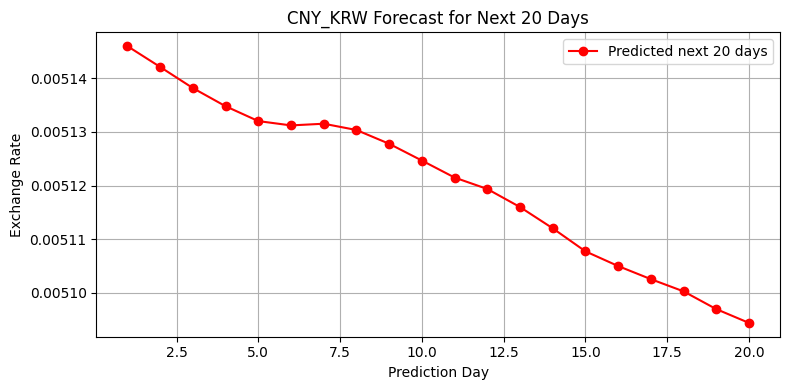

array([0.005146  , 0.00514212, 0.00513818, 0.0051348 , 0.00513203,
       0.00513122, 0.00513154, 0.00513037, 0.0051278 , 0.00512467,
       0.0051215 , 0.00511937, 0.005116  , 0.00511204, 0.00510775,
       0.005105  , 0.00510256, 0.00510028, 0.00509698, 0.0050944 ])

In [68]:
def predict_currency_20(currency: str, look_back: int = 100, scale: int = 1000000):
    """
    带高精度scale的多模态递推预测20天，自动绘图
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from pandas import read_csv
    from sklearn.preprocessing import MinMaxScaler

    # 1. 读取&放大数据，float64
    price_path = f"CNY_{currency}_to_exchange_rate.csv"
    sent_path = f"{currency}_sentiment.csv"
    price_df = read_csv(price_path, header=0, index_col=0)
    sent_df = read_csv(sent_path, header=0, index_col=0)
    df = price_df.join(sent_df, how='inner').astype("float64")
    df.iloc[:, 0] *= scale        # price 列 放大

    # 2. 初始化scaler
    scaler_price = MinMaxScaler()
    scaler_sent = MinMaxScaler()
    scaler_y = MinMaxScaler()
    price = df.iloc[:, 0].values.reshape(-1, 1)
    sent = df.iloc[:, 1].values.reshape(-1, 1)
    price_scaled_full = scaler_price.fit_transform(price)
    sent_scaled_full = scaler_sent.fit_transform(sent)
    y_scaled_full = scaler_y.fit_transform(price)

    history_real = price[-look_back:, 0] / scale    # 后面画图用真实汇率

    # 3. 训练
    model = MultiModalTransformerLSTMModel(price_path, sent_path, look_back=look_back)
    # 覆写scaler (确保递推过程用的归一化与训练保持一致)
    model.scaler_price, model.scaler_sentiment, model.scaler_y = scaler_price, scaler_sent, scaler_y

    (price_train_X, sent_train_X, train_y_scaled), _ = model.load_and_prepare_data()
    model.train(price_train_X, sent_train_X, train_y_scaled, epochs=200, batch_size=64)

    # 4. 初始化递推窗口
    price_scaled = price_scaled_full[-look_back:]
    sent_scaled = sent_scaled_full[-look_back:]
    
    preds = []
    for i in range(20):
        price_input = price_scaled[-look_back:].reshape(1, look_back, 1)
        sent_input = sent_scaled[-look_back:].reshape(1, look_back, 1)
        pred_norm = model.model.predict([price_input, sent_input], verbose=0)
        pred_val_scaled = model.scaler_y.inverse_transform(pred_norm)[0, 0]
        pred_val = pred_val_scaled / scale
        preds.append(pred_val)
        
        next_price_scaled = model.scaler_price.transform([[pred_val_scaled]])
        price_scaled = np.vstack([price_scaled, next_price_scaled])[1:, :]
        sent_scaled = np.vstack([sent_scaled, [sent_scaled[-1]]])[1:, :]
    
    preds = np.array(preds)*scale
    print(f"{currency} 未来20天递推预测：\n{preds}")

    plt.figure(figsize=(8, 4))
    plt.plot(np.arange(1, 21), preds, label="Predicted next 20 days", color='red', marker='o')
    plt.xlabel('Prediction Day')
    plt.ylabel('Exchange Rate')
    plt.title(f'CNY_{currency} Forecast for Next 20 Days')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return preds


predict_currency_20('KRW', look_back=150)
